In [1]:
import numpy as np
from numpy import pi, log, ceil
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, execute
from qiskit_textbook.widgets import scalable_circuit
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import Statevector
from qiskit.circuit import Gate
from qiskit.visualization import array_to_latex, plot_histogram

<h2> Implementation of the Fourier transform, and Inverse Fourier transform gates

In [2]:
def qft_rotations(qc,n):
    if n == 0: return qc
    n -= 1
    qc.h(n)
    for qb in range(n):
        qc.cp(pi/2**(n-qb),qb,n)
    qft_rotations(qc,n)

def iqft_rotations(qc,n,nbits):
    if n == nbits: return qc
    for qb in range(n):
        qc.cp(-pi/2**(n-qb),qb,n)
    qc.h(n)
    n += 1
    iqft_rotations(qc,n,nbits)


In [3]:
def swap_qb(qc,n):
    for qb in range(n//2):
        qc.swap(qb,n-1-qb)
    return qc
    

In [4]:
def F(n):
    qc = QuantumCircuit(n, name='QFT')
    qft_rotations(qc,n)
    swap_qb(qc,n)
    gate = qc.to_gate()
    return gate

def IF(n):
    qc = QuantumCircuit(n, name='IQFT')
    swap_qb(qc,n)
    iqft_rotations(qc,0,n)
    gate = qc.to_gate()
    return gate

<h1> Quantum Phase Estimation

<h2> The operator is the phase operator:
    $$P(\lambda) = \left(\begin{array}{cc} 1 & 0 \\ 0 & e^{i\lambda}\end{array}\right)\,.$$

<h3> We consider the eigenvector $|1\rangle$ with eigenvalue $e^{i\lambda}$,
    $$P(\lambda)|1\rangle = e^{i\lambda}|1\rangle = e^{2\pi i \phi}|1\rangle\,.$$
    This means that the phase is
    $$\phi = \frac{\lambda}{2\pi}\,.$$

In [5]:
# input to the function: number of result qubits, and the value of the phase
def qpe(n_result_qb, phase):
    angle = 2*pi*phase          # angle of the phase operator 
    t = n_result_qb             # use the notation in Nielson and Chuang
    qc = QuantumCircuit(t+1,t)  # the additional qubit is the eigenvector
    qc.x(t)                     # eigenvector of the phase operator |1>
    qc.h(range(t))
    for bit in range(t):
        for i in range(2**(bit)):
            qc.cp(angle, bit, t)    

    qc.barrier()
    qc.append(IF(t),range(t))
    qc.measure(range(t),range(t))
    
    return qc

def simulate(qc, shots):
    prob = dict()
    sim = Aer.get_backend('aer_simulator')
    counts = execute(qc, sim, shots=shots).result().get_counts()
    for key in counts.keys():                 # calculate the probability from counts
        prob[key] = counts[key]/shots
    display(plot_histogram(prob))
    return prob

<h3> Example: <br>
Phase = $\frac{1}{3}$ <br> 
     Accuracy = $4$ bits <br>
     Success Probability = $0.9$

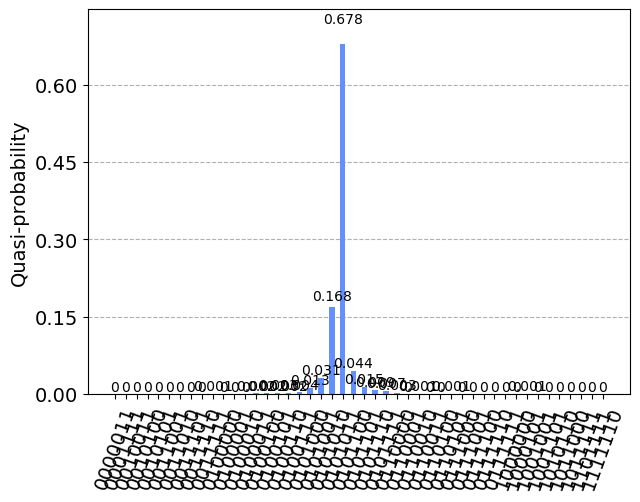

pmax( 0101011 )= 0.677734375


In [6]:
phase = 1/3

accuracy=4;       n= accuracy                  # use Nielson, Chuang notation on page 224
success_prob=0.9; e = 1-success_prob           # use Nielson, Chuang notation on page 224

# compute number of result bits
t = n + ceil(log(2+1/(2*e))/log(2))            # equation (5.35) in Nielson, Chuang on page 224
t = int(t)

qc = qpe(t,phase)

shots = 2**11
prob = simulate(qc, shots)

# get key with maximum probability
prob_max = 0

for key in prob.keys():
     if(prob[key] > prob_max): 
            prob_max = prob[key]
            key_max = key
print("pmax(",key_max,")=",prob_max)

<h3> Verify that the accuracy is obtained with the specified probability

In [10]:
# compute the value of ( phi << accuracy )
# example: 1/3 = 0.01010101...
#          with accuracy 4, val = (0101)_2 = 5
phi_tmp = phase
val = 0
for i in range(accuracy):
    val = 2*val + int(2*phi_tmp)
    phi_tmp = 2*phi_tmp - int(2*phi_tmp)

# get the sum of the probabilities of all measurements
# satisfying the specified accuracy
p = 0
for key in prob.keys():
    if((int(key,2)>>(t-n))==val): print(key,"-->",prob[key]); p = p + prob[key]
print("Actual success probability:", p)
print("Theoretical lower bound on success probability:", success_prob)
if(p < success_prob):
    print("Something is wrong")

0101101 --> 0.0146484375
0101000 --> 0.01318359375
0101110 --> 0.0087890625
0101100 --> 0.04443359375
0101010 --> 0.16845703125
0101001 --> 0.03125
0101011 --> 0.677734375
0101111 --> 0.0068359375
Actual success probability: 0.96533203125
Theoretical lower bound on success probability: 0.9
